In [93]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from model import MultimodalRegressor
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tools import plot_loss_function
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

In [44]:
X_train_text = np.load("data/X_train_text.npy", allow_pickle=True)
X_test_text = np.load("data/X_test_text.npy", allow_pickle=True)
train = pd.read_csv('data/train_preprocessed.csv')
test = pd.read_csv('data/test_preprocessed.csv')

In [45]:
y_train = train['SalaryNormalized']
y_test = test['SalaryNormalized']
X_train_tab = train.drop(columns=['SalaryNormalized'])
X_test_tab = test.drop(columns=['SalaryNormalized'])

In [46]:
X_train_text = torch.tensor(X_train_text, dtype=torch.float32)
X_test_text = torch.tensor(X_test_text, dtype=torch.float32)

X_train_tab = torch.tensor(X_train_tab.values, dtype=torch.float32)
X_test_tab = torch.tensor(X_test_tab.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [47]:
def prepare_dataloaders(batch_size, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test):
    train_dataset = TensorDataset(X_train_text, X_train_tab, y_train)
    test_dataset = TensorDataset(X_test_text, X_test_tab, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [56]:
def train_evaluate(model, optimizer, criterion, epochs, train_loader, test_loader, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    history = {"train_loss": [], "test_loss": [], 'r2': []}

    best_loss = float("inf")
    patience_counter = 0 
    
    for epoch in range(epochs):
        train_loss = 0.0
        # -----------TRAIN-------------
        model.train()
        for text_batch, tab_batch, y_batch in train_loader:
            text_batch = text_batch.to(device)
            tab_batch = tab_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            preds = model(text_batch, tab_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * text_batch.size(0)
    
        avg_train_loss = train_loss / len(train_loader.dataset)

        # -----------EVALUATE-------------
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for text_batch, tab_batch, y_batch in test_loader:
                text_batch = text_batch.to(device)
                tab_batch = tab_batch.to(device)
                y_batch = y_batch.to(device)
            
                preds_test = model(text_batch, tab_batch)
                loss = criterion(preds_test, y_batch)

                test_loss += loss.item() * text_batch.size(0) 
                
                all_preds.append(preds_test.detach().cpu())
                all_targets.append(y_batch.detach().cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        avg_test_loss = test_loss / len(test_loader.dataset)
        r2 = r2_score(all_targets, all_preds)
        
        print(f"Epoch {epoch+1}/{epochs} - test_loss: {avg_test_loss:.4f}")
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['r2'].append(r2)

        # early stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
    return history

In [57]:
model = MultimodalRegressor(text_dim=X_train_text.shape[1], tab_dim=X_train_tab.shape[1], dropout=0.3)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

In [58]:
train_loader, test_loader = prepare_dataloaders(128, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test)

Epoch 1/20 - test_loss: 0.3975
Epoch 2/20 - test_loss: 0.3781
Epoch 3/20 - test_loss: 0.3669
Epoch 4/20 - test_loss: 0.3596
Epoch 5/20 - test_loss: 0.3547
Epoch 6/20 - test_loss: 0.3558
Epoch 7/20 - test_loss: 0.3551
Epoch 8/20 - test_loss: 0.3465
Epoch 9/20 - test_loss: 0.3479
Epoch 10/20 - test_loss: 0.3403
Epoch 11/20 - test_loss: 0.3393
Epoch 12/20 - test_loss: 0.3370
Epoch 13/20 - test_loss: 0.3378
Epoch 14/20 - test_loss: 0.3351
Epoch 15/20 - test_loss: 0.3325
Epoch 16/20 - test_loss: 0.3323
Epoch 17/20 - test_loss: 0.3359
Epoch 18/20 - test_loss: 0.3302
Epoch 19/20 - test_loss: 0.3325
Epoch 20/20 - test_loss: 0.3299


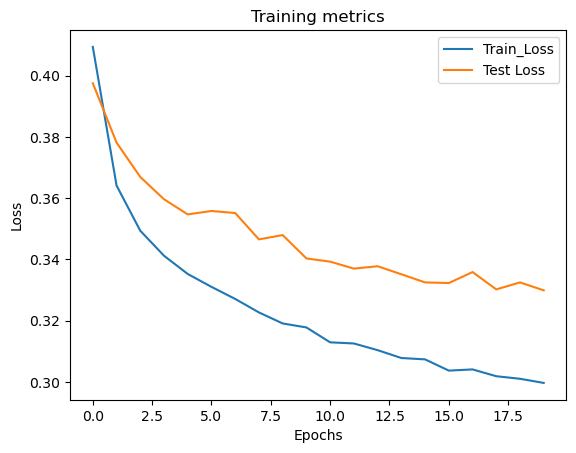

In [59]:
history = train_evaluate(model, optimizer, loss_func, epochs, train_loader, test_loader)
plot_loss_function(history['train_loss'], history['test_loss'])

In [62]:
print(history['r2'][-1])

0.6673527359962463


In [63]:
X_test_combined = np.hstack([X_test_text, X_test_tab])

In [82]:
X_test_text_tensor = X_test_text.clone().detach().requires_grad_(True)
X_test_tab_tensor  = X_test_tab.clone().detach().requires_grad_(True)
y_test_tensor      = y_test.clone().detach()
model.to(device)
X_test_text_tensor = X_test_text_tensor.to(device)
X_test_tab_tensor  = X_test_tab_tensor.to(device)
y_test_tensor      = y_test_tensor.to(device)

In [83]:
ig = IntegratedGradients(model)

In [85]:
batch_size = 64
attr_text_list = []
attr_tab_list = []

for i in range(0, X_test_text_tensor.shape[0], batch_size):
    X_text_batch = X_test_text_tensor[i:i+batch_size].to(device)
    X_tab_batch  = X_test_tab_tensor[i:i+batch_size].to(device)

    attr_text_batch, attr_tab_batch = ig.attribute(
        inputs=(X_text_batch, X_tab_batch),
        target=0,
        n_steps=20,
        return_convergence_delta=False
    )
    attr_text_list.append(attr_text_batch.detach().cpu())
    attr_tab_list.append(attr_tab_batch.detach().cpu())

# Scal wszystko z powrotem
attr_text = torch.cat(attr_text_list, dim=0)
attr_tab = torch.cat(attr_tab_list, dim=0)


In [104]:
text_feature_names = [f"text_{i}" for i in range(X_train_text.shape[1])]
tab_feature_names  = list((train.drop(columns=['SalaryNormalized'])).columns)

In [ ]:
attr_text_mean = attr_text.abs().mean(dim=0).detach().numpy()
attr_tab_mean = attr_tab.abs().mean(dim=0).detach().numpy()

feature_names = list(text_feature_names) + list(tab_feature_names)
importances = np.concatenate([attr_text_mean, attr_tab_mean])

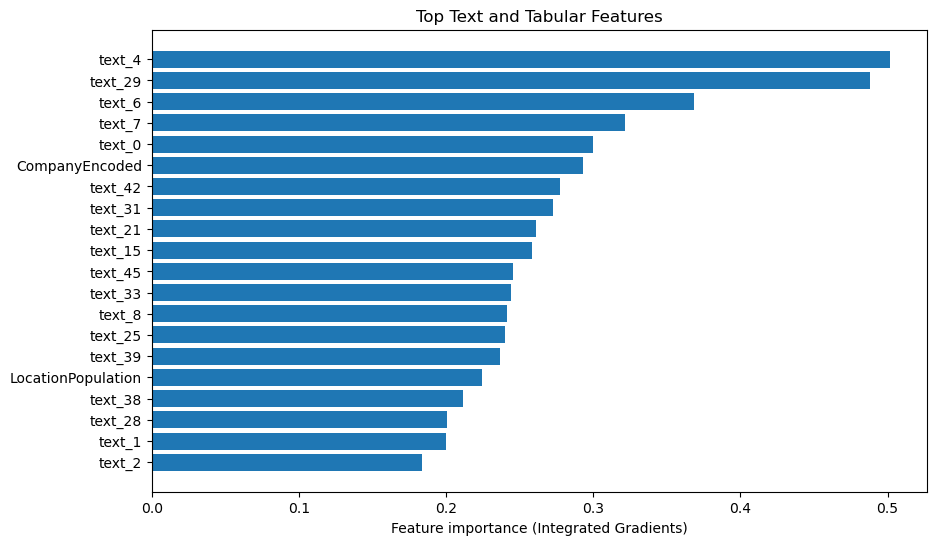

In [107]:
top_k = 20
sorted_idx = np.argsort(importances)[::-1][:top_k]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature importance (Integrated Gradients)")
plt.title("Top Text and Tabular Features")
plt.gca().invert_yaxis()
plt.show()

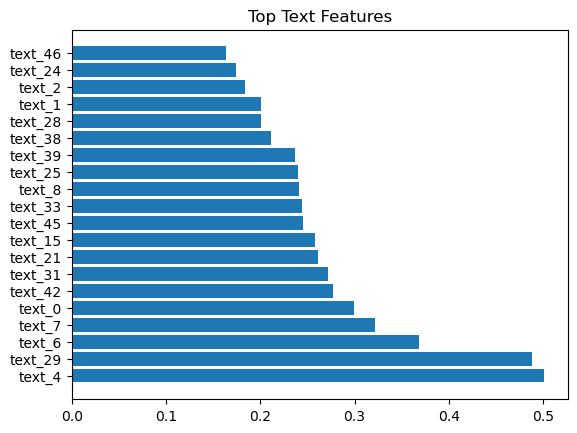

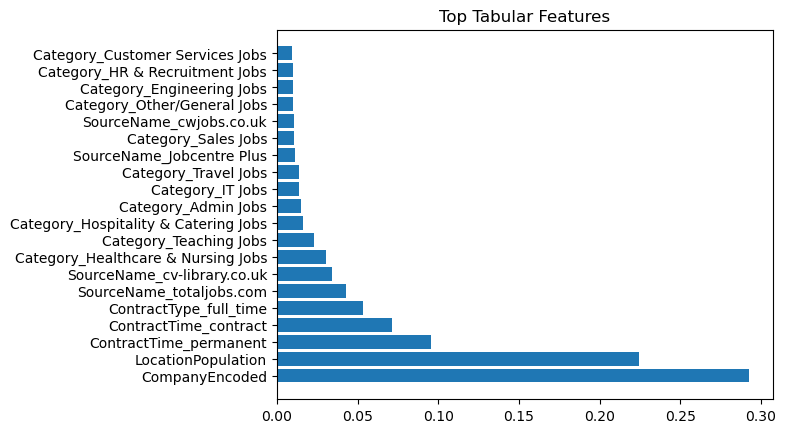

In [108]:
sorted_idx_text = np.argsort(attr_text_mean)[::-1][:20]
plt.barh(np.array(text_feature_names)[sorted_idx_text], attr_text_mean[sorted_idx_text])
plt.title("Top Text Features")
plt.show()

# Tab
sorted_idx_tab = np.argsort(attr_tab_mean)[::-1][:20]
plt.barh(np.array(tab_feature_names)[sorted_idx_tab], attr_tab_mean[sorted_idx_tab])
plt.title("Top Tabular Features")
plt.show()

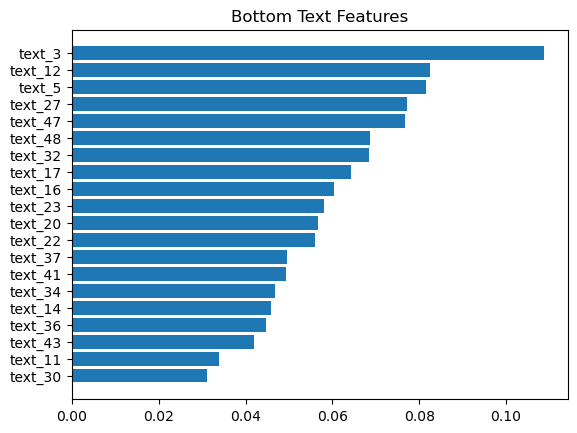

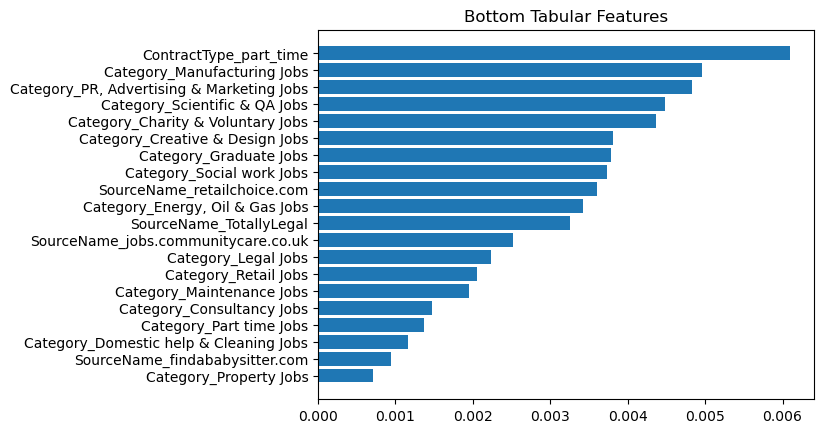

In [109]:
# --- Bottom Text Features ---
bottom_k = 20
sorted_idx_text = np.argsort(attr_text_mean)[:bottom_k]  # najmniejsze wartości
plt.barh(np.array(text_feature_names)[sorted_idx_text], attr_text_mean[sorted_idx_text])
plt.title("Bottom Text Features")
plt.show()

# --- Bottom Tabular Features ---
sorted_idx_tab = np.argsort(attr_tab_mean)[:bottom_k]  # najmniejsze wartości
plt.barh(np.array(tab_feature_names)[sorted_idx_tab], attr_tab_mean[sorted_idx_tab])
plt.title("Bottom Tabular Features")
plt.show()
